# MLP GAN MNIST

This notebook is a demonstration for a simple GAN training on MNIST by using KnetLayers. Let's get started!

In [1]:
using Pkg; for p in ("Colors","ImageMagick","Images"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet, KnetLayers, Colors, ImageMagick, Images, Statistics
import Knet: Data
import KnetLayers: arrtype
setoptim!(model,optimizer) = for p in params(model) p.opt=Knet.clone(optimizer) end # Easy optimizer setter
#Data
include(Knet.dir("data","mnist.jl"))

┌ Info: Recompiling stale cache file /Users/ekin/.julia/compiled/v1.1/Knet/f4vSz.ji for Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/ekin/.julia/compiled/v1.1/KnetLayers/ZXBRh.ji for KnetLayers [80bfaf46-ad8a-11e8-19eb-a135e382307b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/ekin/.julia/compiled/v1.1/ImageMagick/0LbNX.ji for ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/ekin/.julia/compiled/v1.1/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1184


## Discriminator and Generator Networks

Discriminator and Generator networks are defined as `D` and `G` respectively. Loss functions `𝑱d` and `𝑱g` are defined according to the equation X in GAN paper. Sample noise function `𝒩` is a normal distribution. Loss functions are defined according to the equations in Algorithm 1 section of the [paper](https://arxiv.org/abs/1406.2661 "arXiv"). We use a slightly modified generator loss according to [GAN tricks](https://github.com/soumith/ganhacks#2-a-modified-loss-function "GAN Tricks").
$$ J_d = -\frac{1}{m} \sum_{i=1}^{m} log(D(x^{(i)}) + log(1-D(G(z^{(i)})))$$
$$ J_g = -\frac{1}{m} \sum_{i=1}^{m} log(D(G(z^{(i)}))) $$ 

*`𝜀` is used to prevent log functions from resulting NaN values.

In [2]:
global const 𝜀=Float32(1e-8)
𝑱d(D,x,Gz) = -mean(log.(D(x) .+ 𝜀) .+ log.((1+𝜀) .- D(Gz)))/2   #discriminator loss
𝑱g(D,G,z)  = -mean(log.(D(G(z)) .+ 𝜀)) # generator loss          
𝒩(input, batch) = arrtype(randn(Float32, input, batch))  #sample noise

𝒩 (generic function with 1 method)

## Train & Test Function

This `runmodel` function is implementing training procedure described in GAN paper. It first update discriminator with specified optimizer, then update generator network. Same function can be used in test mode by passing `train` argument as false. In the test mode it calculates losses instead of gradients.

In [3]:
function runmodel(D, G, data, 𝞗; dtst=nothing, train=false, saveinterval=20)
    gloss = dloss = total= 0.0; B = 𝞗[:batchsize]    
    if train
        Dprms, Gprms, L = params(D), params(G), 𝞗[:epochs] 
    else
        Dprms, Gprms, L = nothing, nothing, 1
    end
    
    for i=1:L
        for (x,_) in data     
            Gz = G(𝒩(𝞗[:ginp], B)) #Generate Fake Images
            z = 𝒩(𝞗[:ginp], 2B)     #Sample z from Noise

            if train 
                jd = @diff 𝑱d(D, x, Gz)
                for w in Dprms update!(w,grad(jd,w))  end
                jg = @diff 𝑱g(D, G, z)
                for w in Gprms update!(w,grad(jg,w))  end
            else
                jd = 𝑱d(D, x, Gz)
                jg = 𝑱g(D, G, z)
            end          
            dloss += 2B*value(jd); gloss += 2B*value(jg); total += 2B            
        end
        train ? runmodel(D, G, dtst, 𝞗; train=false) : println((gloss/total, dloss/total))
        i % saveinterval == 0 && generate_and_show(D, G, 100, 𝞗)  # save 10 images
    end
end

runmodel (generic function with 1 method)

## Generate and Display

This function generates a random `number` of images and displays them.

In [5]:
function generate_and_show(D,G,number,𝞗)
    Gz    = convert(Array,G(𝒩(𝞗[:ginp], number))) .> 0.5
    Gz    = reshape(Gz, (28, 28, number))
    L     = floor(Int, sqrt(number))
    grid  = []
    for i = 1:L:number
        push!(grid, reshape(permutedims(Gz[:,:,i:i+L-1], (2,3,1)), (L*28,28)))
    end
    display(Gray.(hcat(grid...)))
end

generate_and_show (generic function with 1 method)

## Model&Data Run
We will load MNIST data and initalize our MLP models


In [6]:
𝞗 = Dict(:batchsize=>32,:epochs=>80,:ginp=>256,:genh=>512,:disch=>512,:optim=>Adam(;lr=0.0002))
G = Chain(MLP(𝞗[:ginp], 𝞗[:genh], 784; activation=ELU()), Sigm())
D = Chain(MLP(784, 𝞗[:disch], 1; activation=ELU()), Sigm())
setoptim!(D, 𝞗[:optim]); setoptim!(G, 𝞗[:optim])

In [7]:
xtrn,ytrn,xtst,ytst = mnist()
global dtrn,dtst = mnistdata(xsize=(784,:),xtype=arrtype, batchsize=𝞗[:batchsize]) 

┌ Info: Loading MNIST...
└ @ Main /Users/ekin/.julia/dev/Knet/data/mnist.jl:33


(Data{Tuple{Array{Float32,2},Array{UInt8,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x05 0x0a … 0x06 0x08], 32, 60000, false, 59969, 1:60000, false, (784, Colon()), (60000,), Array{Float32,N} where N, Array{UInt8,1}), Data{Tuple{Array{Float32,2},Array{UInt8,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x07 0x02 … 0x05 0x06], 32, 10000, false, 9969, 1:10000, false, (784, Colon()), (10000,), Array{Float32,N} where N, Array{UInt8,1}))

## RUN!

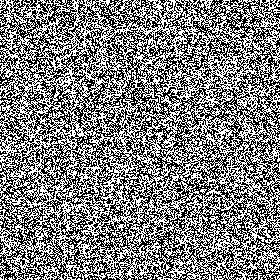

(0.5725320814511715, 0.7633941244238462)
(3.757010958897762, 0.08246376914664721)
(3.124031757697081, 0.17143887453354323)
(2.6480280436002293, 0.2663734230475548)
(2.222289816691325, 0.3838006578958951)
(2.6380726328262916, 0.3150782165571283)
(2.4936755146735754, 0.2730667415337685)
(2.440090148112713, 0.30623872434863675)
(2.591330717771481, 0.24278122110244554)
(2.97639208420729, 0.29732600274758464)
(3.119292745987574, 0.22396401898601118)
(4.250656330432648, 0.25675608401294225)


InterruptException: InterruptException:

In [8]:
generate_and_show(D, G, 100, 𝞗)
runmodel(D, G, dtst, 𝞗; train=false) # initial losses
runmodel(D, G, dtrn, 𝞗; train=true, dtst=dtst) # training

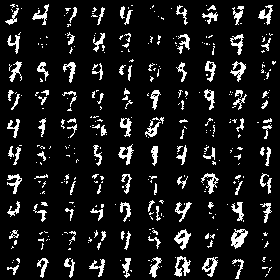

In [9]:
generate_and_show(D, G, 100, 𝞗)